In [1000]:
# setup
import pandas as pd
import spacy
import re
from string import punctuation
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Data Collection

In [1001]:
# read the reddit file
with open('si650-f21-reddit-questions.txt') as f:
    reddit_questions = f.read()
    #print(reddit_questions)

In [1002]:
# read the wikipedia biography file
with open('si650.f21.wiki-bios.10k.txt') as f:
    wiki_bio = f.read()
    #print(wiki_bio)?

In [1003]:
# read the stopword file
with open('stoplist.txt') as f:
    stoplist = f.read()
    #print(stoplist)

# Data Wrangling

In [1004]:
#separate the different documents into different element in list.
list_reddit_questions=reddit_questions.split("\n")
list_wiki_bio=wiki_bio.split("\n")
list_stopwords = stoplist.split("\n")
len(list_reddit_questions),len(list_clean_wiki_bio), len(list_stopwords)

(20001, 10001, 419)

In [1005]:
def remove_uninteresting(collection):
    '''Takes a collection of documents and removes punctuation, digits and extra spaces.'''
    clean_collection =[]
    for doc in collection:
        digit_removed = re.sub(r"\b[0-9]+\b\s*", "", doc) #remove puntuation
        punctuation_removed = re.sub(r"[^A-Za-z0-9\s]+", "", digit_removed) #removes digigts
        clean_text = re.sub(r"\s\s+", " ", punctuation_removed); #remove the extra spaces
        clean_collection.append(clean_text)
    return clean_collection       

In [1006]:
nlp = spacy.load("en_core_web_sm")
def tokenize(collection):
    '''Tokenize the text in given collection of documents'''
    tokenized_collection=[]
    token_info_collection=[]
    doc_count =0
    for doc in collection:
        tokens = nlp(doc)
        doc_count +=1
        for token in tokens:
            #print(token.text, token.pos_, token.tag_)
            token_info_collection.append([token.text, token.pos_,'doc'+ str(doc_count)])
        tokenized_collection.append(tokens)
    return token_info_collection    

In [1008]:
# pass a collection
clean_wiki_bio = remove_uninteresting(list_wiki_bio)
token_info_wiki_bio = tokenize(clean_wiki_bio)

#create wikipedia biographies dataframe
df_wiki_bio = pd.DataFrame(token_info_wiki_bio, columns = ['word', 'pos', 'doc'])
df_wiki_bio.sample(1)

,word,pos,doc
1839391,defeat,NOUN,doc8942


In [1060]:
# pass a collection
clean_reddit_questions = remove_uninteresting(list_reddit_questions)
token_info_reddit_questions = tokenize(clean_reddit_questions)

#create reddit questions dataframe
df_reddit_questions = pd.DataFrame(token_info_reddit_questions, columns = ['word', 'pos','doc'])
# df_reddit_questions.tail(20)

,word,pos,doc
7538,Targets,NOUN,doc499
7539,entire,ADJ,doc499
7540,computer,NOUN,doc499
7541,system,NOUN,doc499
7542,went,VERB,doc499
7543,down,ADV,doc499
7544,yesterday,NOUN,doc499
7545,What,PRON,doc500
7546,is,AUX,doc500
7547,something,PRON,doc500


In [1076]:
# create df with the stopwords
df_stopwords= pd.DataFrame(list_stopwords, columns = ['word'])

In [1077]:
stoplist.isupper() # there is no capital word in the stoplist

False

Since, many words differ only because they are uppercase, having a column with the words in lowercase will be helpful in finding word frequency and removal of stopwords which are all in lower case.

In [1078]:
df_wiki_bio['lowercase_word'] = df_wiki_bio.word.str.lower()
df_reddit_questions['lowercase_word'] = df_reddit_questions.word.str.lower()

In [1079]:
# df_wiki_bio.sample(2)

In [1080]:
# calculate freq of lowercase words
df_wiki_bio['freq'] = df_wiki_bio.groupby('lowercase_word')['lowercase_word'].transform('count')
df_reddit_questions['freq'] = df_wiki_bio.groupby('lowercase_word')['lowercase_word'].transform('count')
# df_wiki_bio.sample(5)

In [1081]:
# drop duplicates because we have their info in the freq column now
df_wiki_bio.drop_duplicates(inplace=True)
df_reddit_questions.drop_duplicates(inplace=True)

In [1082]:
# df_wiki_bio.info()

In [1232]:
# create a dataframe only with lowercase words
df_wiki_bio_lowercase = df_wiki_bio[['lowercase_word','pos','freq','doc']].copy()
df_wiki_bio_lowercase.drop_duplicates(inplace=True)
df_reddit_questions_lowercase = df_reddit_questions[['lowercase_word','pos','freq','doc']].copy()
df_reddit_questions_lowercase.drop_duplicates(inplace=True)

In [1233]:
# sort as per word freq. for convenience and add rank column
df_wiki_bio_lowercase_sorted = df_wiki_bio_lowercase.sort_values('freq', ascending=False).reset_index()
df_wiki_bio_lowercase_sorted['rank'] = df_wiki_bio_lowercase_sorted.index+1
df_wiki_bio_lowercase_sorted.drop(columns='index', inplace=True)
df_reddit_questions_lowercase_sorted = df_reddit_questions_lowercase.sort_values('freq', ascending=False).reset_index()
df_reddit_questions_lowercase_sorted['rank'] = df_reddit_questions_lowercase_sorted.index+1
df_reddit_questions_lowercase_sorted.drop(columns='index', inplace=True)

In [1310]:
df_reddit_questions_lowercase_sorted.sample(10)

,lowercase_word,pos,freq,doc,rank,is_stopword
2117,and,CCONJ,254.0,doc268,2118,True
6781,it,PRON,NaN,doc384,6782,True
2829,be,AUX,73.0,doc466,2830,True
6788,threat,NOUN,NaN,doc384,6789,False
4042,food,NOUN,1.0,doc427,4043,False
4753,rumor,NOUN,NaN,doc80,4754,False
6370,sound,PROPN,NaN,doc321,6371,False
2081,own,ADJ,277.0,doc453,2082,True
1629,writing,VERB,499.0,doc453,1630,False
2314,single,ADJ,180.0,doc439,2315,False


Some of the stopwords contain apostrophe but I have removed it from the collection of documents and so I will remove it from the stopword list as well.

In [1086]:
#remove puntuation from stopword
clean_list_stopwords = remove_uninteresting(list_stopwords)
len(clean_list_stopwords)

419

In [1284]:
# remove the stopwords from the df
df_wiki_bio_lowercase_sorted['is_stopword'] = df_wiki_bio_lowercase_sorted.lowercase_word.apply(lambda x: 
                            True if x in clean_list_stopwords else False)
df_reddit_questions_lowercase_sorted['is_stopword'] = df_reddit_questions_lowercase_sorted.lowercase_word.apply(
    lambda x: True if x in clean_list_stopwords else False)

In [1285]:
df_wiki_bio_lowercase_sorted.head(), df_reddit_questions_lowercase_sorted.head()

(  lowercase_word  pos   freq      doc  rank  is_stopword
 0             in  ADP  12298  doc2913     1         True
 1             in  ADP  12298  doc7422     2         True
 2             in  ADP  12298  doc6387     3         True
 3             in  ADP  12298  doc4018     4         True
 4             in  ADP  12298  doc1788     5         True,
   lowercase_word    pos     freq     doc  rank  is_stopword
 0              s  PROPN  12298.0  doc275     1        False
 1             of    ADP  12298.0  doc117     2         True
 2            got   VERB  12298.0  doc201     3        False
 3           good    ADJ  12298.0    doc3     4        False
 4            but  CCONJ  12298.0  doc109     5         True)

## Plotting the frequency distribution of words

In [1089]:
df1 = df_wiki_bio_lowercase_sorted[df_wiki_bio_lowercase_sorted.is_stopword == False]
df1.head(1)

,lowercase_word,pos,freq,rank,is_stopword
37,born,VERB,4923,38,False


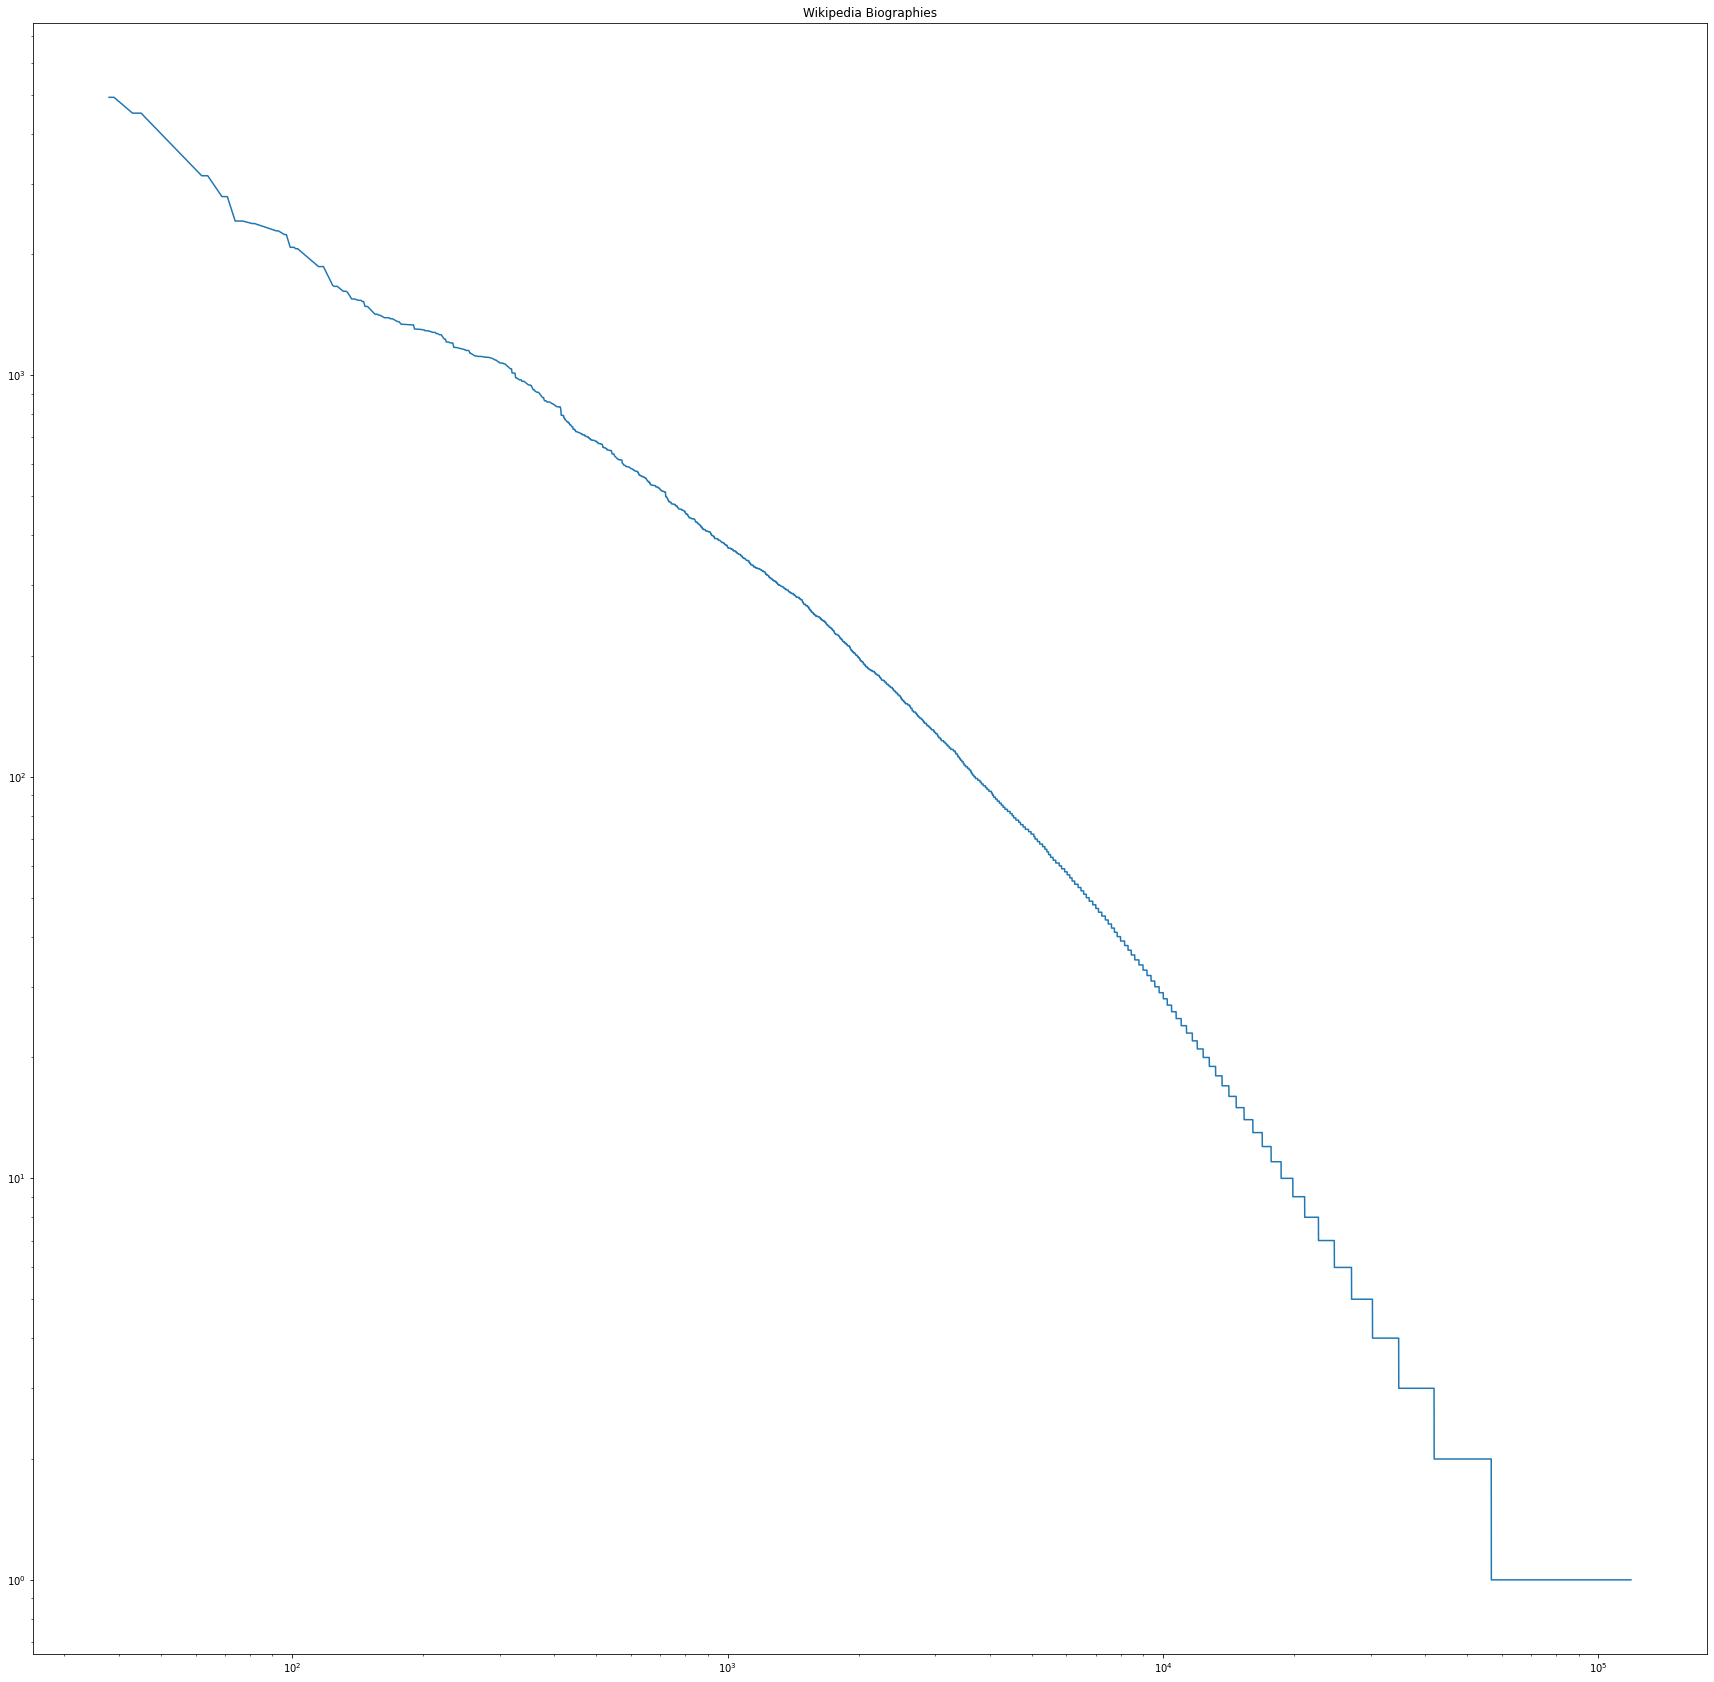

In [1090]:
# plt.subplot(2,1,1)
plt.xscale('log')
plt.plot(df1['rank'],df1['freq'])
plt.yscale('log')
plt.rcParams["figure.figsize"] = (30,30)
# plt.xticks(df['rank'], df['freq'])
plt.title('Wikipedia Biographies')
plt.show()

In [1317]:
df2 = df_reddit_questions_lowercase_sorted[df_reddit_questions_lowercase_sorted.is_stopword == False]
df2.head(10)

,lowercase_word,pos,freq,doc,rank,is_stopword
0,s,PROPN,12298.0,doc275,1,False
2,got,VERB,12298.0,doc201,3,False
3,good,ADJ,12298.0,doc3,4,False
5,post,VERB,12298.0,doc473,6,False
7,story,NOUN,12298.0,doc433,8,False
8,jealousy,NOUN,12298.0,doc222,9,False
11,deserves,VERB,12298.0,doc229,12,False
14,lover,NOUN,12298.0,doc385,15,False
16,avoided,VERB,12298.0,doc300,17,False
22,know,VERB,12298.0,doc457,23,False


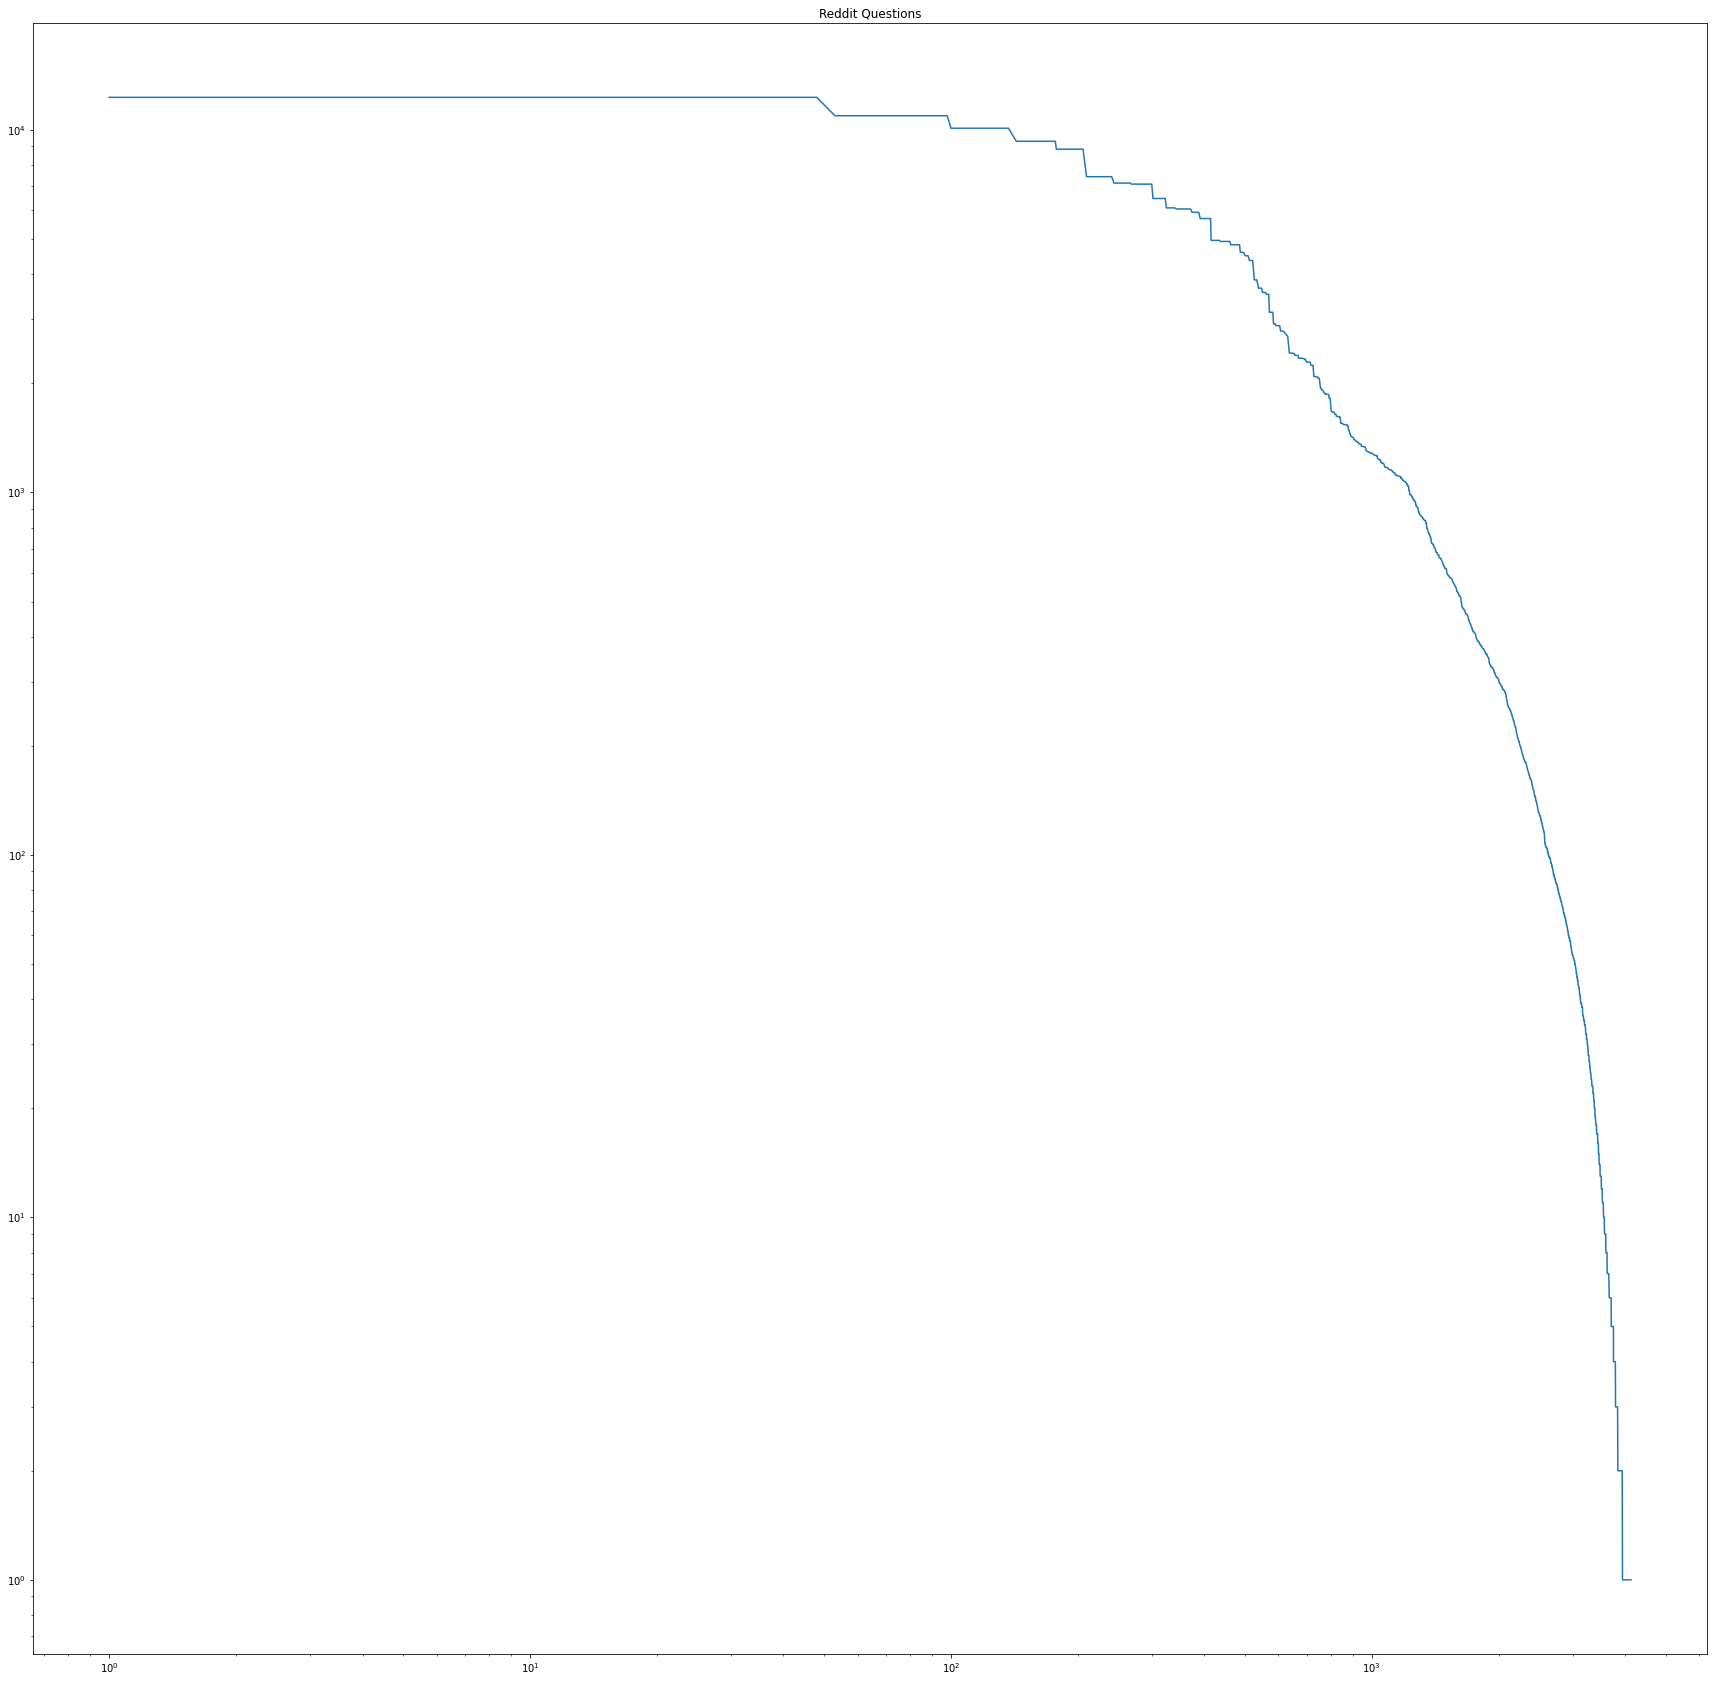

In [1318]:
plt.xscale('log')
plt.plot(df2['rank'],df2['freq'])
plt.yscale('log')
plt.rcParams["figure.figsize"] = (30,30)
# plt.xticks(df['rank'], df['freq'])
plt.title('Reddit Questions')
plt.show()

The plots do not look like power-law distribution. Instead they depict an inverse relationship. My two plts look different from each other. The wikipedia biographies graph is more of a straight line but the reddit question shows an inverse curve almost, because there are a few words which have same frequency and they give a flattened appeareance to the curve at the top.

## Frequency of stopwords

In [1319]:
df_wiki_stopwords = df_wiki_bio_lowercase_sorted[df_wiki_bio_lowercase_sorted.is_stopword == True]
df_wiki_stopwords.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236700 entries, 0 to 1048330
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   lowercase_word  236700 non-null  object
 1   pos             236700 non-null  object
 2   freq            236700 non-null  int64 
 3   doc             236700 non-null  object
 4   rank            236700 non-null  int64 
 5   is_stopword     236700 non-null  bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 11.1+ MB


In [1320]:
df_wiki_stopwords.freq.sum()

1002019959

In [1321]:
df_reddit_stopwords = df_reddit_questions_lowercase_sorted[df_reddit_questions_lowercase_sorted.is_stopword 
                                                           == True]
df_reddit_stopwords.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 1 to 7388
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lowercase_word  4225 non-null   object 
 1   pos             4225 non-null   object 
 2   freq            2362 non-null   float64
 3   doc             4225 non-null   object 
 4   rank            4225 non-null   int64  
 5   is_stopword     4225 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 202.2+ KB


In [1322]:
df_reddit_stopwords.freq.sum()

3293545.0

The frequency of stopwords is much higher in the wiki collection that in the reddit collection. This might because reddit questions are short, thus packed with rare words which provide context, unlike wikipedia biographies which are long.

## Percentage of capital letters

For this analysis I have not removed stopwords because there are stopwords which contain the capital letter and I wanted to retain it for an accurate percentage. I have removed the punctuatuation and digits though because the percentage is in terms of letters.

In [1355]:
# create column to indicate if word has capital letter
df_wiki_bio['capital_letter']= df_wiki_bio.word.apply(lambda x: any(character.isupper() for character in x))
df_reddit_questions['capital_letter']= df_reddit_questions.word.apply(
    lambda x: any(character.isupper() for character in x))
df_wiki_bio.head()

,word,pos,doc,lowercase_word,freq,capital_letter,word_length
0,Francesco,PROPN,doc1,francesco,31,True,9
1,Redenti,PROPN,doc1,redenti,1,True,7
2,was,AUX,doc1,was,7133,False,3
3,an,DET,doc1,an,4363,False,2
4,Italian,ADJ,doc1,italian,293,True,7


In [1356]:
# create column to reflect the word length
df_wiki_bio ['word_length'] = df_wiki_bio.word.str.len()
df_reddit_questions ['word_length'] = df_reddit_questions.word.str.len()
df_wiki_bio.head(2), df_reddit_questions.head(2)

(        word    pos   doc lowercase_word  freq  capital_letter  word_length
 0  Francesco  PROPN  doc1      francesco    31            True            9
 1    Redenti  PROPN  doc1        redenti     1            True            7,
        word   pos   doc lowercase_word  freq  capital_letter  word_length
 0  Fastfood   ADJ  doc1       fastfood  31.0            True            8
 1   workers  NOUN  doc1        workers   1.0           False            7)

In [1373]:
# select rows with capital letters
df_wiki_bio_capital = df_wiki_bio[df_wiki_bio.capital_letter == True]
df_reddit_questions_capital = df_reddit_questions[df_reddit_questions.capital_letter == True]
# df_wiki_bio_capital.iloc[a].freq.sum()
# count the capital letters
# wiki_capital_index = df_wiki_bio_capital.head(5).word.str.findall('[A-Z]').index.tolist()
wiki_capital_letters = df_wiki_bio_capital.freq.sum()
wiki_total_letters = df_wiki_bio.freq.sum()
reddit_capital_letters = df_reddit_questions_capital.freq.sum()
reddit_total_letters = df_reddit_questions.freq.sum()
# a=df_wiki_bio_capital.freq.sum()
wiki_total_letters,reddit_total_letters

(1480331352, 5918478.0)

In [1372]:
Percentage_wiki_capital = wiki_capital_letters/wiki_total_letters *100
Percentage_reddit_capital = reddit_capital_letters/reddit_total_letters *100
Percentage_wiki_capital, Percentage_reddit_capital

(22.897547670124602, 11.850664985153278)

the % of capital letters in wikipedia biographies is higher than in the reddit questions which might be because the no.of words in wikipedia biographies is more that the total word count in reddit question. Also, reddit is not a formal platform, so, people might not follow rules of grammar there all the time. 

## Average Characters per word

Here I am choosing df without stopwords because they do not add more information in this regard.

In [1125]:
df_wiki.head()

,lowercase_word,pos,freq,rank,is_stopword
37,born,VERB,4923,38,False
38,born,PROPN,4923,39,False
42,career,NOUN,4496,43,False
43,career,PROPN,4496,44,False
44,career,VERB,4496,45,False


In [1128]:
# leave out the stopwords
df_wiki = df_wiki_bio_lowercase_sorted[df_wiki_bio_lowercase_sorted.is_stopword == False].copy()
df_reddit = df_reddit_questions_lowercase_sorted[df_reddit_questions_lowercase_sorted.is_stopword == False].copy()

df_wiki ['word_length'] = df_wiki.lowercase_word.str.len()
df_reddit ['word_length'] = df_reddit.lowercase_word.str.len()

#sum of word length of all words
wiki_total_letters = df_wiki.word_length.sum()
reddit_total_letters = df_reddit.word_length.sum()
wiki_total_letters,reddit_total_letters

(891875, 15384)

In [1132]:
# total  no.of words in the collection
df_wiki.shape[0], df_reddit.shape[0]

(117916, 2583)

Since fraction of avg. characters per word won't mean anything, I am rounding the output.

In [1133]:
# sum of word length of all words / the total no.of words in the collection
round(wiki_total_letters/df_wiki.shape[0]), round(reddit_total_letters/df_reddit.shape[0])

(8.0, 6.0)

We observe the average characters per word is higher in wikipedia biographies.

## Percentage of nouns, adjectives, verbs, adverbs, and pronouns

In [ ]:
df_wiki.tail(15)

In [1134]:
# get count of nouns, adjectives, verbs, adverbs, and pronouns
noun_count_wiki = df_wiki[df_wiki.pos == 'NOUN']
adj_count_wiki = df_wiki[df_wiki.pos == 'ADJ']
verb_count_wiki = df_wiki[df_wiki.pos == 'VERB']
adverb_count_wiki = df_wiki[df_wiki.pos == 'ADV']
pronoun_count_wiki = df_wiki[df_wiki.pos == 'PROPN']

noun_count_reddit = df_reddit[df_reddit.pos == 'NOUN']
adj_count_reddit = df_reddit[df_reddit.pos == 'ADJ']
verb_count_reddit = df_reddit[df_reddit.pos == 'VERB']
adverb_count_reddit = df_reddit[df_reddit.pos == 'ADV']
pronoun_count_reddit = df_reddit[df_reddit.pos == 'PROPN']

In [1140]:
noun_count_wiki.freq.sum()/df_wiki.freq.sum()*100, noun_count_reddit.freq.sum()/df_reddit.freq.sum()*100

(25.553123415543304, 43.68809891077719)

In [1141]:
adj_count_wiki.freq.sum()/df_wiki.freq.sum()*100, adj_count_reddit.freq.sum()/df_reddit.freq.sum()*100

(10.701058672924862, 16.69388658149255)

In [1142]:
verb_count_wiki.freq.sum()/df_wiki.freq.sum()*100, verb_count_reddit.freq.sum()/df_reddit.freq.sum()*100

(18.963830380749148, 27.152649669815652)

In [1143]:
adverb_count_wiki.freq.sum()/df_wiki.freq.sum()*100, adverb_count_reddit.freq.sum()/df_reddit.freq.sum()*100

(2.5211538675217295, 2.649301717160093)

In [1144]:
pronoun_count_wiki.freq.sum()/df_wiki.freq.sum()*100, pronoun_count_reddit.freq.sum()/df_reddit.freq.sum()*100

(40.16939468564087, 6.353689954902123)

The percentage of all except Pronouns is higher in reddit questions. Since in biographies there is an often reference to the person the biography is about, it makes sense that the percentage of Pronouns is higher.

## The top 10 nouns, top 10 verbs, and top 10 adjectives

Since, the df is sorted by frequency, the first 10 will be the top 10.

In [1152]:
noun_count_wiki.lowercase_word.head(10), noun_count_reddit.lowercase_word.head(10)

(42         career
 61           life
 75          later
 80         school
 91     university
 100         years
 117      national
 125          time
 138         world
 142       college
 Name: lowercase_word, dtype: object,
 1      minutes
 2       sports
 11       story
 12        food
 14        info
 15       mouth
 23    jealousy
 29     parents
 35       lover
 38    students
 Name: lowercase_word, dtype: object)

In [1153]:
adj_count_wiki.lowercase_word.head(10), adj_count_reddit.lowercase_word.head(10)

(63         life
 69        early
 76        later
 95          new
 116    national
 130      played
 154     married
 162      second
 174    american
 189    personal
 Name: lowercase_word, dtype: object,
 4            drunk
 6             good
 7      respectable
 22            best
 49        juiciest
 62         serious
 70        favorite
 77          common
 83           crazy
 100           live
 Name: lowercase_word, dtype: object)

In [1154]:
verb_count_wiki.lowercase_word.head(10), verb_count_reddit.lowercase_word.head(10)

(37         born
 44       career
 98        years
 114    national
 123        died
 126        time
 131      played
 133        made
 137       world
 141     college
 Name: lowercase_word, dtype: object,
 8          got
 9         went
 13     avoided
 18     reading
 20        know
 24    deserves
 30        post
 59        make
 61     removed
 69     respond
 Name: lowercase_word, dtype: object)

In [1155]:
adverb_count_wiki.lowercase_word.head(10), adverb_count_reddit.lowercase_word.head(10)

(68             early
 74             later
 166           second
 203    international
 281             high
 338             left
 381             home
 409             best
 444            south
 463            third
 Name: lowercase_word, dtype: object,
 96       absolutely
 188          matter
 201            long
 320        actually
 356            back
 393          longer
 431        suddenly
 535        actually
 598         forever
 644    accidentally
 Name: lowercase_word, dtype: object)

In [1156]:
pronoun_count_wiki.lowercase_word.head(10), pronoun_count_reddit.lowercase_word.head(10)

(38           born
 43         career
 62           life
 70          early
 73          later
 81         school
 92     university
 96            new
 99          years
 101           two
 Name: lowercase_word, dtype: object,
 28               s
 79        exretail
 97      basketball
 112         reddit
 130         reddit
 133           kong
 166         reddit
 181       students
 230    programming
 235           sexy
 Name: lowercase_word, dtype: object)

This gives an interesting context because the words associated with wikipedia biographies are education, career and personal life related, while as in case of reddit question the content might be of gossip, sports, and fun type.

## TF-IDF

In [1288]:
doc_list=['doc1','doc2','doc3','doc4','doc5','doc6','doc7','doc8','doc9','doc10']
#remove stopwords because they are unncessary, even though their TF-IDF will not be significant 
df_wiki = df_wiki_bio_lowercase_sorted[df_wiki_bio_lowercase_sorted.is_stopword == False]
df_wiki_10 = df_wiki[df_wiki.doc.isin(doc_list)].copy()

In [1289]:
df_wiki_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 92196 to 1003675
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   lowercase_word  1097 non-null   object
 1   pos             1097 non-null   object
 2   freq            1097 non-null   int64 
 3   doc             1097 non-null   object
 4   rank            1097 non-null   int64 
 5   is_stopword     1097 non-null   bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 52.5+ KB


In [1292]:
# calculate tf
df_wiki_10['tf']= np.log(df_wiki_10.freq + 1)

In [1296]:
#no.of doc containing term
df_new = df_wiki_10.groupby('lowercase_word').doc.count().reset_index()
df_new.head()

,lowercase_word,doc
0,1930s,1
1,19th,1
2,3rd,1
3,49ers,1
4,6th,1


In [1331]:
# merge 2 dfs
df_tf_idf = pd.merge(df_wiki_10, df_new, on='lowercase_word')
df_tf_idf.rename({'doc_y': 'doc_freq'}, axis=1, inplace=True) #rename column
df_tf_idf['idf'] = 1+ np.log(10000/df_tf_idf.doc_freq)
df_tf_idf['tf_idf'] = df_tf_idf.tf* df_tf_idf.idf #calculate tf-idf
df_tf_idf= df_tf_idf[df_tf_idf.tf_idf.notna()] # remove rows with NaN value
df_tf_idf

,lowercase_word,pos,freq,doc_x,rank,is_stopword,tf,doc_freq,idf,tf_idf
0,born,VERB,4923,doc7,92197,False,8.501876,5,8.600902,73.123810
1,born,VERB,4923,doc1,92250,False,8.501876,5,8.600902,73.123810
2,born,VERB,4923,doc8,92285,False,8.501876,5,8.600902,73.123810
3,born,VERB,4923,doc4,92351,False,8.501876,5,8.600902,73.123810
4,born,VERB,4923,doc3,93217,False,8.501876,5,8.600902,73.123810
...,...,...,...,...,...,...,...,...,...,...
1092,hubbells,PROPN,1,doc8,1003306,False,0.693147,1,10.210340,7.077269
1093,panamacalifornia,PROPN,1,doc8,1003421,False,0.693147,1,10.210340,7.077269
1094,lummis,PROPN,1,doc8,1003443,False,0.693147,1,10.210340,7.077269
1095,chelly,ADV,1,doc8,1003656,False,0.693147,1,10.210340,7.077269


In [1332]:
df = df_tf_idf[['lowercase_word','tf_idf','doc_x']] #take desired df subset
df.head()

,lowercase_word,tf_idf,doc_x
0,born,73.12381,doc7
1,born,73.12381,doc1
2,born,73.12381,doc8
3,born,73.12381,doc4
4,born,73.12381,doc3


In [1333]:
#create the tf-idf top 5 sorted list for top 10 docs
doc1= df[df.doc_x == 'doc1'].sort_values('tf_idf').head(5)
doc2= df[df.doc_x == 'doc2'].sort_values('tf_idf').head(5)
doc3= df[df.doc_x == 'doc3'].sort_values('tf_idf').head(5)
doc4= df[df.doc_x == 'doc4'].sort_values('tf_idf').head(5)
doc5= df[df.doc_x == 'doc5'].sort_values('tf_idf').head(5)
doc6= df[df.doc_x == 'doc6'].sort_values('tf_idf').head(5)
doc7= df[df.doc_x == 'doc7'].sort_values('tf_idf').head(5)
doc8= df[df.doc_x == 'doc8'].sort_values('tf_idf').head(5)
doc9= df[df.doc_x == 'doc9'].sort_values('tf_idf').head(5)
doc10= df[df.doc_x == 'doc10'].sort_values('tf_idf').head(5)

In [1334]:
doc1, doc2, doc3, doc4, doc5, doc6, doc7, doc8,doc9,doc10

(     lowercase_word     tf_idf doc_x
 1034     fischietto   7.077269  doc1
 1074        redenti   7.077269  doc1
 984     caricatures  11.217205  doc1
 975       correggio  14.154537  doc1
 751       francesco  35.386343  doc1,
     lowercase_word     tf_idf doc_x
 910       bearcats  19.868405  doc2
 807        maxwell  31.085610  doc2
 780         deacon  32.865818  doc2
 710         arnold  37.664715  doc2
 637   northwestern  41.280930  doc2,
      lowercase_word     tf_idf doc_x
 1024     watlington   7.077269  doc3
 1026     windglider   7.077269  doc3
 980       bermudian  11.217205  doc3
 982      windsurfer  11.217205  doc3
 626            hugh  41.804652  doc3,
      lowercase_word    tf_idf doc_x
 1080          kohat  7.077269  doc4
 1048           brar  7.077269  doc4
 1047           zias  7.077269  doc4
 1044         savita  7.077269  doc4
 1042      allotting  7.077269  doc4,
      lowercase_word     tf_idf doc_x
 1063         sangjo   7.077269  doc5
 607         cyclist

The words do give a an idea of what the document is about but it is not a good summary because it lacks context. The words are rare and leaves it to imagination as to how to connect them. 

## Position Indexing
We can also weigh terms taking into account its position in the docuemnt or position in terms of other words or the sequence of words in the query, but that cannot be directly calculated from the inverted index. The advantage of position indexing is the we can do phrase queries which allows us to look for words in the exact same order. This increases the probability of finding the most relevant document.

# Simple Search

In [878]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# import seaborn as sns

In [879]:
#initialize countvectorize object with given stopwords
count_vectorizer=CountVectorizer(stop_words= clean_list_stopwords) 
def convert_to_vector(corpus):
    '''Converts documents to vectors'''
    sparse_matrix= count_vectorizer.fit_transform(corpus)
    return sparse_matrix.todense()

In [880]:
doc_term_matrix=convert_to_vector(list_reddit_questions[0:10])
doc_term_matrix.shape

(10, 73)

In [847]:
df=pd.DataFrame (doc_term_matrix, columns=count_vectorizer.get_feature_names(), 
                 index=['1','2','3','4','5','6','7','8','9','10'])
df


,30,9mm,absolute,absolutely,actually,amanda,amazing,amp,avoid,brin,...,two,ve,versa,vice,viewers,witnessed,work,workers,years,zurich
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
10,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [881]:
def query_to_vector(query):
    '''This function generates matrix for text of the size of corpus it fit on'''
    sparse_matrix= count_vectorizer.transform([query])
    return sparse_matrix.todense() # or sparse_matrix2.toarray()

In [851]:
# vectorize the queries
query1 = query_to_vector('programming')
query2 = query_to_vector('pets')
query3 = query_to_vector('college')
query4 = query_to_vector('love')
query5 = query_to_vector('food')

In [855]:
cosine_similarity(doc_term_matrix,query1)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [856]:
cosine_similarity(doc_term_matrix,query2)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [857]:
cosine_similarity(doc_term_matrix,query3)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [858]:
cosine_similarity(doc_term_matrix,query4)

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.57735027],
       [0.33333333],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [859]:
cosine_similarity(doc_term_matrix,query5)

array([[0.33333333],
       [0.5       ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

#### The NDCG for the queries:
 - $NDCG(programming)_{10}$ = 0
 - $NDCG(pets)_{10}$ = 0
 - $NDCG(college)_{10}$ = 0
 - $NDCG(love)_{10}$ = 2/log5 +1/log6 = 2/2.322 + 1/2.585 = 1.25
 - $NDCG(food)_{10}$ = 1 + 2/log2 = 3

This system would work best for queries which are single word based or  multiple words based, where the order of the words in the query does not matter. So, for phrase based query where we might want to give importance to the sequence of the words in a document, this system will fall short.

## Plotting terms in the vocab field

In [869]:
doc_500 = convert_to_vector(list_reddit_questions[0:500]).shape[1]
doc_1K = convert_to_vector(list_reddit_questions[0:1000]).shape[1]
doc_5K = convert_to_vector(list_reddit_questions[0:5000]).shape[1]
doc_10K = convert_to_vector(list_reddit_questions[0:10000]).shape[1]
doc_20K = convert_to_vector(list_reddit_questions[0:20000]).shape[1]

In [876]:
df =pd.DataFrame([doc_term_matrix.shape[1],doc_500,doc_1K,doc_5K,doc_10K,doc_20K],
#                  ['doc_500K','doc_1000K','doc_5000K','doc_10000K','doc_20000K']],
                columns=['no_of_terms'])
df['doc_size'] =['10','500','1000','5000','10000','20000']
df

,no_of_terms,doc_size
0,73,10
1,1473,500
2,2325,1000
3,6162,5000
4,8870,10000
5,12567,20000


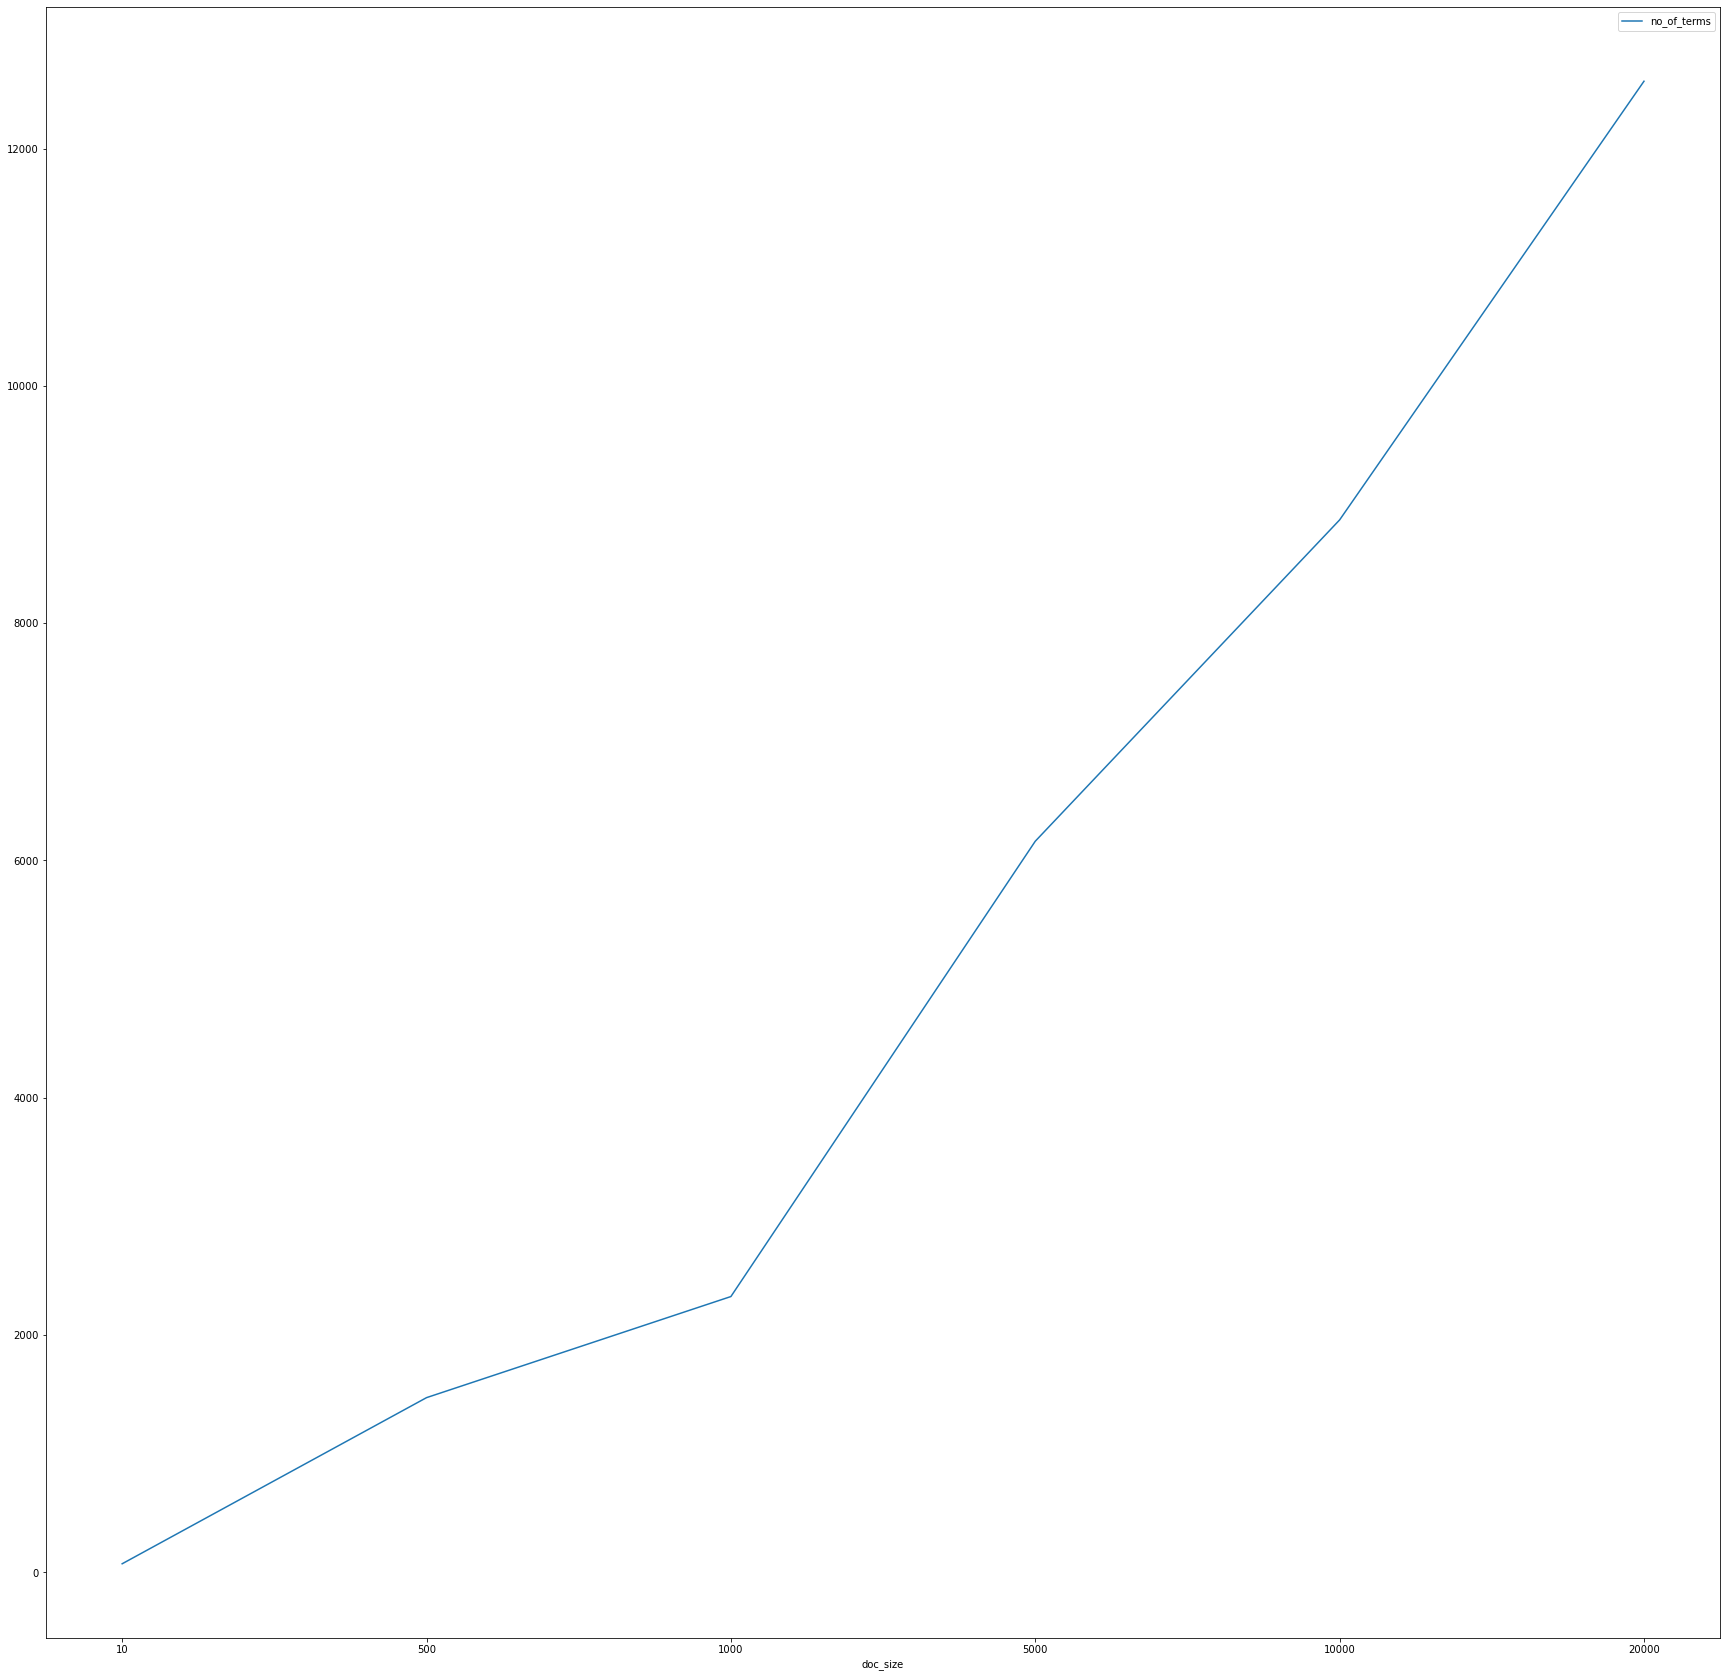

In [877]:
df.plot('doc_size','no_of_terms',kind='line')

The greater the no.of documents, more are the no.of terms. So, there is a linear relationship and the complexity is O(n). This is not scalable because in practice we usually have a much higher no.of documents, which translates to more computation time and space required.